#1.Fetching data of stock in same sector to find best pairs which is highly cointegrated

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

#fetching data 
stock = ["HDFCBANK.NS","ICICIBANK.NS","SBIN.NS","KOTAKBANK.NS","INDUSINDBK.NS","AUBANK.NS","IDFCFIRSTB.NS","BANKBARODA.NS","PNB.NS","AXISBANK.NS","FEDERALBNK.NS","CANBK.NS"]
data = yf.download(stock, start="2024-08-28", end="2025-08-28", interval="1d").dropna()

[*********************100%***********************]  12 of 12 completed


#2.Visualizing the cointegrated pairs

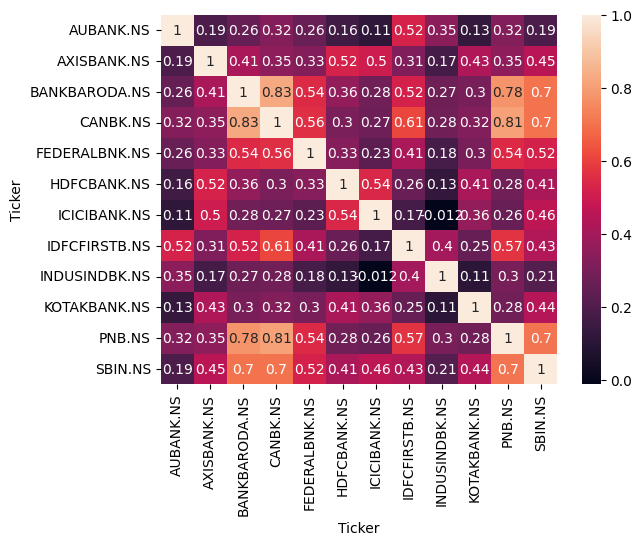

In [16]:
#calculating return
returns = data["Close"].pct_change()

#correlation 
corr_matrix = returns.corr()

#ploting
sns.heatmap(corr_matrix, annot=True)
plt.show()

#3.From the heatmap we choose optimal pair which gives better correlation

In [17]:
pairs = pd.DataFrame(columns=["stock_1","stock_2","adf_result"])
for i in stock:
    for j in stock:
        if i == j:
            continue
        else:
            stock_a = data["Close"][i]
            stock_b = data["Close"][j]

            #linear regression 
            stock_b_costant = sm.add_constant(stock_b)
            linear_regression = sm.OLS(stock_a ,stock_b_costant).fit()

            beta = linear_regression.params[1]
            spread = stock_a - (stock_b * beta)

            adf_result = adfuller(spread)
            if adf_result[1] < 0.05:
                pairs.loc[len(pairs)] = [i,j,adf_result[1]]

C:\Users\Laptop\AppData\Local\Temp\ipykernel_11116\2050302018.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = linear_regression.params[1]
C:\Users\Laptop\AppData\Local\Temp\ipykernel_11116\2050302018.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = linear_regression.params[1]
C:\Users\Laptop\AppData\Local\Temp\ipykernel_11116\2050302018.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = linear_regress

#4.From the pairs table pickup minimal adf value
  --> the minimum adf value is the best cointegated pair

**ADF test :**

The Augmented Dickey-Fuller (ADF) test is a statistical test used in time series analysis to determine whether a given time series is stationary or not.

Key points about the ADF test:
 - It tests the null hypothesis (
H
0
 ) that the time series has a unit root, meaning it is non-stationary (its statistical properties such as mean and variance change over time).

- The alternative hypothesis (
H
1
 ) is that the time series is stationary (no unit root).

- The "augmented" part means the test includes lagged differences of the time series to account for higher-order autocorrelation.

- The test outputs a statistic; the more negative this value, the stronger the evidence against the null hypothesis of non-stationarity. 

-->After this we will find Z-score

In [18]:
pair_with_min_adf = pairs.loc[pairs["adf_result"].idxmin()]
stock_a = data["Close"][pair_with_min_adf["stock_1"]]
stock_b = data["Close"][pair_with_min_adf["stock_2"]]
print(f"The best pair is {pair_with_min_adf["stock_1"]} and {pair_with_min_adf["stock_2"]}")

#Z-score
stock_b_as_constant = sm.add_constant(stock_b) #Taking stock_b as a constant
linear_regression = sm.OLS(stock_a ,stock_b_as_constant).fit() #Ordinary Least Squares (OLS) regression
beta = linear_regression.params[1] #hedge ratio
spread = stock_a - beta * stock_b
zscore = (spread - spread.mean())/spread.std() #Z-score

The best pair is BANKBARODA.NS and SBIN.NS


C:\Users\Laptop\AppData\Local\Temp\ipykernel_11116\1516806122.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta = linear_regression.params[1] #hedge ratio


#5.Visualize Z-score

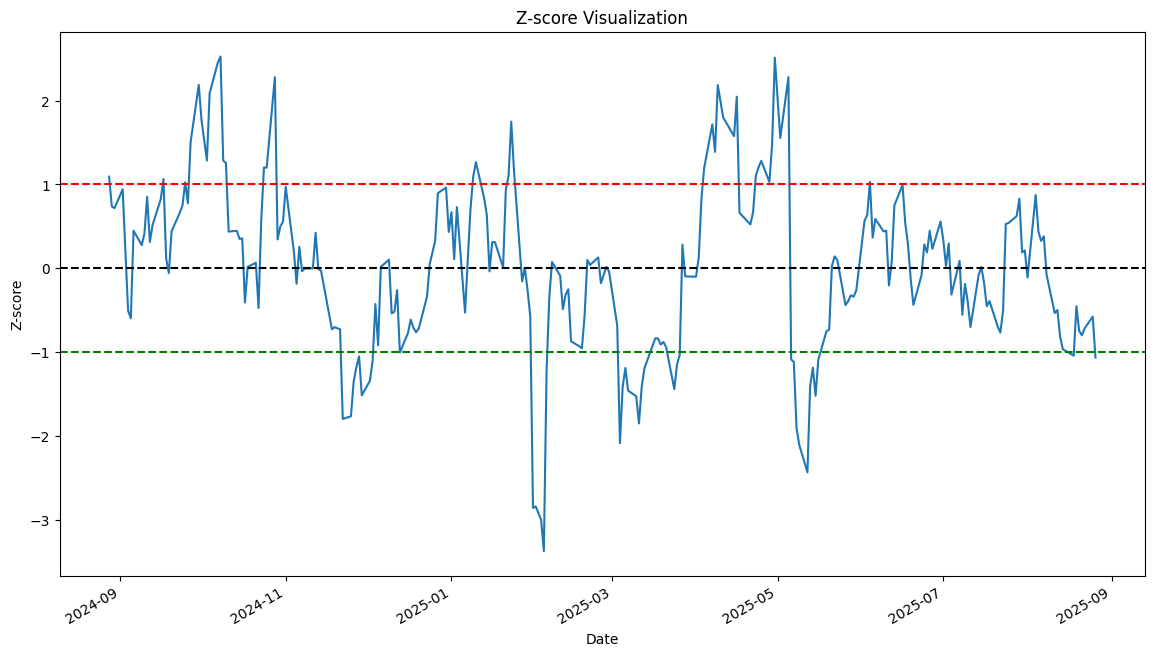

In [19]:
zscore.plot(figsize=(14,8))
plt.title("Z-score Visualization")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.axhline(0, color="black", linestyle="--")
plt.axhline(1, color="red", linestyle="--")
plt.axhline(-1, color="green", linestyle="--")
plt.show()

#6.Generating signal and position 

C:\Users\Laptop\AppData\Local\Temp\ipykernel_11116\2238537730.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  execute["signal"].iloc[i] = -1
C:\Users\Laptop\AppData\Local\Temp\ipykernel_11116\2238537730.py:18: SettingWithCopyWarning: 
A

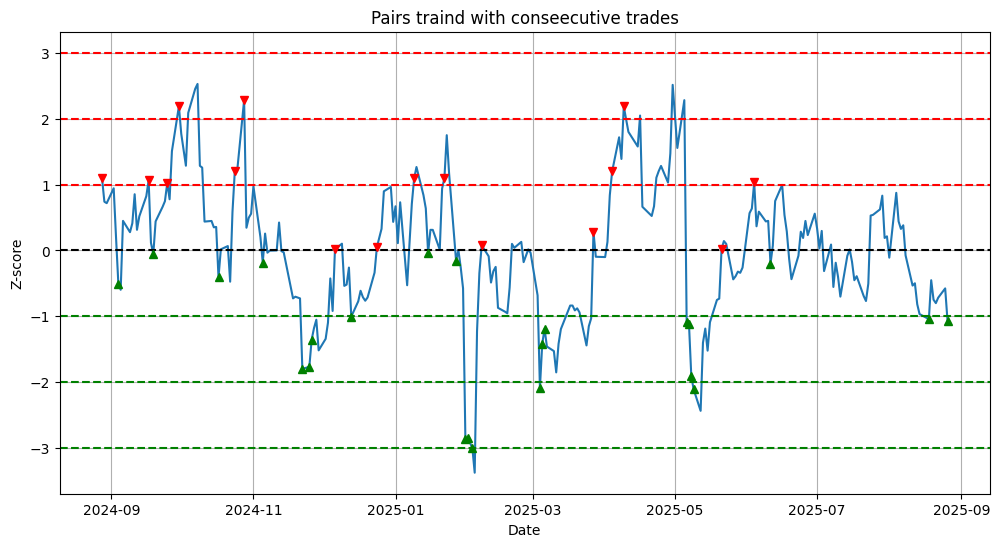

In [20]:
execute = pd.DataFrame({"zscore":zscore})
upper_threshold_1 = 1.0
upper_threshold_2 = 2.0
upper_threshold_3 = 3.0
lower_threshold_1 = -1.0
lower_threshold_2 = -2.0
lower_threshold_3 = -3.0
exit_threshold = 0.0
position = 0
execute["signal"] = 0
    
for i in range(len(execute.index)):
    current_zscore = execute["zscore"].iloc[i]
    
    #for short position
    if position <= 0:
        if current_zscore >= upper_threshold_1 and position == 0:
            execute["signal"].iloc[i] = -1
            position = -1
            
        elif current_zscore >= upper_threshold_2 and position == -1:
            execute["signal"].iloc[i] = -1
            position = -2
            
        elif current_zscore >= upper_threshold_3 and position == -2:
            execute["signal"].iloc[i] = -1
            position = -3
     
    #for long position       
    if position >= 0:
        if current_zscore <= lower_threshold_1 and position == 0:
            execute["signal"].iloc[i] = 1
            position = 1
            
        elif current_zscore <= lower_threshold_1 and position == 1:
            execute["signal"].iloc[i] = 1
            position = 2
            
        elif current_zscore <= lower_threshold_1 and position == 2:
            execute["signal"].iloc[i] = 1
            position = 3
     
    #for exit       
    if position < 0 and current_zscore <= exit_threshold: #Exit short
        execute["signal"].iloc[i] = 1 
        position = 0
    elif position > 0 and current_zscore >= exit_threshold: #Exit long
        execute["signal"].iloc[i] = -1
        position = 0

plt.figure(figsize=(12,6))
plt.plot(execute["zscore"])
plt.axhline(upper_threshold_1, color = "r", linestyle="--")
plt.axhline(upper_threshold_2, color = "r", linestyle="--")
plt.axhline(upper_threshold_3, color = "r", linestyle="--")
plt.axhline(lower_threshold_1, color = "g", linestyle="--")
plt.axhline(lower_threshold_2, color = "g", linestyle="--")
plt.axhline(lower_threshold_3, color = "g", linestyle="--")
plt.axhline(exit_threshold, color = "k", linestyle="--")
plt.plot(execute.index[execute["signal"]==1],execute["zscore"][execute["signal"] == 1], '^' , color="green", label="buy")
plt.plot(execute.index[execute["signal"]==-1],execute["zscore"][execute["signal"] == -1],'v', color="red", label="sell")

plt.title("Pairs traind with conseecutive trades")
plt.xlabel("Date")
plt.ylabel("Z-score")
plt.grid(True)
plt.show()    

#7.Taking trade and calculating returns

In [ ]:
#daily return of both stocks
execute["daily_return_stock_a"] = execute["stock_a"].pct_change()
execute["daily_return_stock_b"] = execute["stock_b"].pct_change()

#appling temporary stock signal
execute["signal_stock_a"] = 0
execute["signal_stock_b"] = 0

#signal for individual stock
execute["signal_stock_a"] = execute["signal"]
execute["signal_stock_b"] = -execute["signal"]

#return for individual stock
execute["strategy_returns_stock_a"] = execute["daily_return_stock_a"] * execute["signal_stock_a"].shift(1)
execute["strategy_returns_stock_b"] = execute["daily_return_stock_b"] * execute["signal_stock_b"].shift(1)

#calculating cumulative return for individual stock
execute["cumulative_strategy_return_stock_a"] = (1 + execute['strategy_returns_stock_a']).cumprod() - 1
execute["cumulative_strategy_return_stock_b"] = (1 + execute['strategy_returns_stock_b']).cumprod() - 1

#calculating overall portfolio growth having 70% of stock a and 30% of stock b
execute["portfolio_growth"] = 0.7*(execute["cumulative_strategy_return_stock_a"]) + 0.3*(execute["cumulative_strategy_return_stock_b"])